# 1 Data reading part

In [11]:
from google.cloud.sql.connector import Connector, IPTypes
import sqlalchemy
from google.oauth2 import service_account
from sqlalchemy import text
import time
import pandas as pd
import numpy as np
from spyder_kernels.utils.iofuncs import load_dictionary
from datetime import datetime, timedelta
import statsmodels.api as sm
#!pip install cloud-sql-python-connector

In [2]:
SERVICE_ACCOUNT_FILE = 'C:\\Users\\User\\Desktop\\qf5214\\qf5214_wxc.json'
                                                            #各自修改成自己的密钥文件
# 创建服务账户凭据
credentials = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE
)

connector = Connector(credentials=credentials)

def getconn() -> sqlalchemy.engine.base.Connection:
    instance_connection_string = "supple-folder-418707:us-central1:qf5214project-replica"
    db_user = "user_wxc"
    db_pass = "5214group4_cloud_wxc"
    db_name = "Bitcoin_data"                                     

    conn = connector.connect(
        instance_connection_string,
        "pymysql",  
        user=db_user,
        password=db_pass,
        db=db_name,
        ip_type=IPTypes.PUBLIC,  # 使用公共IP进行访问
    )
    return conn

# 创建SQLAlchemy engine
engine = sqlalchemy.create_engine(
    "mysql+pymysql://",  # 我们的数据库是MySQL8.0
    creator=getconn,
)

## very slow!!!! The data is too big.   About 15 mins 

In [3]:
start_time = time.time()

query = "SELECT * FROM news"
news_data = pd.read_sql(query, engine)
    
query = "SELECT * FROM market"
market_data = pd.read_sql(query, engine)

query = "SELECT * FROM talk_comments"
talk_comments = pd.read_sql(query, engine)

query = "SELECT * FROM talk_subjects"
talk_subjects = pd.read_sql(query, engine)

query = "SELECT * FROM talk_users"
talk_users = pd.read_sql(query, engine)

end_time = time.time()

# 2 Data cleaning processing part

In [6]:
news_data = news_data.reset_index(drop=True)
market_data = market_data.reset_index(drop=True)
talk_comments = talk_comments.reset_index(drop=True)
talk_subjects = talk_subjects.reset_index(drop=True)
talk_users = talk_users.reset_index(drop=True)

news_data['date'] = pd.to_datetime(news_data['date'], format='%Y-%m-%d')
talk_comments['date'] = pd.to_datetime(talk_comments['date'], format='%Y-%m-%d')
market_data['date'] = pd.to_datetime(market_data['date'], format='%Y-%m-%d')
talk_subjects['date'] = pd.to_datetime(talk_subjects['date'], format='%Y-%m-%d')


market_data.dropna(subset=['btc_price'], inplace=True) 
market_data = market_data.reset_index(drop=True)

# 3 Calculate and store market factors

In [7]:
def quantile_past(today_date, window, data, col_name):   #返回当日数据在过去window内的分位数
    start_date = today_date - timedelta(days=window-1)
    end_date = today_date
    mask = (data['date'] >= start_date) & (data['date'] <= end_date)
    data_in_range = data.loc[mask]

    today_data = data[data['date'] == today_date]

    values = data_in_range[col_name]

    quantile = values.rank(pct=True)
        
    today_quantile = quantile.loc[today_data.index].iloc[0]
    
    return today_quantile

In [12]:
data_index = pd.DataFrame()                                              #存放因子的
data_index['date'] = market_data['date']

# 3.1 计算日度bitcoin收益率
data_index['btc_price_growth'] = market_data['btc_price'].pct_change()   #计算日度收益率
data_index = data_index.reset_index(drop=True)

# 3.2 cpi 300天分位点
data_index['cpi_quant'] = np.nan
window = 300
data = market_data
col_name = 'cpi'
for Date in data_index['date']:
    data_index.loc[data_index['date'] == Date, 'cpi_quant'] = quantile_past(Date, window, data, col_name)

# 3.3 nonfarm_rate 300天分位点
data_index['nofarm_quant'] = np.nan
window = 300
data = market_data
col_name = 'nofarm_ratio'
for Date in data_index['date']:
    data_index.loc[data_index['date'] == Date, 'nofarm_quant'] = quantile_past(Date, window, data, col_name)

# 3.4 fed_rate 300天分位点
data_index['fed_quant'] = np.nan
window = 300
data = market_data
col_name = 'fed_rate'
for Date in data_index['date']:
    data_index.loc[data_index['date'] == Date, 'fed_quant'] = quantile_past(Date, window, data, col_name)

# 3.5 bit_volume 300天分位点
data_index['btc_price_quant'] = np.nan
window = 300
data = market_data
col_name = 'btc_price'
for Date in data_index['date']:
    data_index.loc[data_index['date'] == Date, 'btc_price_quant'] = quantile_past(Date, window, data, col_name)
    
# 3.6 bit_volume 300天分位点
data_index['btc_volume_quant'] = np.nan
window = 300
data = market_data
col_name = 'btc_volume'
for Date in data_index['date']:
    data_index.loc[data_index['date'] == Date, 'btc_volume_quant'] = quantile_past(Date, window, data, col_name)

# 3.7 eth_price 300天分位点
data_index['eth_price_quant'] = np.nan
window = 300
data = market_data
col_name = 'eth_price'
for Date in data_index['date']:
    data_index.loc[data_index['date'] == Date, 'eth_price_quant'] = quantile_past(Date, window, data, col_name)

# 4 Calculate and store Calculate and store news forum factors
## very slow!!!! from 2010 -- 2024

In [13]:
socialmedia_data = pd.DataFrame()                                              #存放因子的
socialmedia_data['date'] = market_data['date']
socialmedia_data['comment_count'] = np.nan
socialmedia_data['comment_sentiment_mean'] = np.nan   
socialmedia_data['comment_sentiment_std'] = np.nan    
socialmedia_data['subject_count'] = np.nan    
socialmedia_data['subject_emotion'] = np.nan    
socialmedia_data['subject_subjectivity'] = np.nan  
socialmedia_data['news_count'] = np.nan    
socialmedia_data['news_emotion'] = np.nan    
socialmedia_data['news_subjectivity'] = np.nan   


specific_date = pd.to_datetime('2024-01-01')
for specific_date in socialmedia_data['date']:
    daily_comments = talk_comments[talk_comments['date'].dt.date == specific_date.date()]
    comment_count = daily_comments.shape[0]                                               #每日评论数
    comment_sentiment_mean = daily_comments['talk_comment_sentiment'].mean()              #每日评论情绪化平均
    comment_sentiment_std = daily_comments['talk_comment_sentiment'].std()                #每日评论情绪化标准差

    socialmedia_data.loc[socialmedia_data['date'] == specific_date , 'comment_count'] = comment_count
    socialmedia_data.loc[socialmedia_data['date'] == specific_date , 'comment_sentiment_mean'] = comment_sentiment_mean
    socialmedia_data.loc[socialmedia_data['date'] == specific_date , 'comment_sentiment_std'] = comment_sentiment_std

    daily_subjects = talk_subjects[talk_subjects['date'].dt.date == specific_date.date()]
    subject_count = daily_subjects.shape[0]                                              #每日论坛数
    subject_emotion = daily_subjects['talk_subject_emotion'].mean()                      #每日论坛情绪化平均
    subject_subjectivity = daily_subjects['talk_subject_subjectivity'].mean()            #每日论坛主观性平均

    socialmedia_data.loc[socialmedia_data['date'] == specific_date , 'subject_count'] = subject_count 
    socialmedia_data.loc[socialmedia_data['date'] == specific_date , 'subject_emotion'] = subject_emotion
    socialmedia_data.loc[socialmedia_data['date'] == specific_date , 'subject_subjectivity'] = subject_subjectivity
    
    daily_news = news_data[news_data['date'].dt.date == specific_date.date()]
    news_count = daily_news.shape[0]                                                 #每日新闻数
    news_emotion = daily_news['news_title_emotion'].mean()                           #每日新闻情绪化平均
    news_subjectivity = daily_news['news_title_subjectivity'].mean()                 #每日新闻主观性平均  

    socialmedia_data.loc[socialmedia_data['date'] == specific_date , 'news_count'] = news_count
    socialmedia_data.loc[socialmedia_data['date'] == specific_date , 'news_emotion'] = news_emotion  
    socialmedia_data.loc[socialmedia_data['date'] == specific_date , 'news_subjectivity'] = news_subjectivity 
    
    if specific_date.day == 1:
        print(specific_date)

2010-08-01 00:00:00
2010-09-01 00:00:00
2010-10-01 00:00:00
2010-11-01 00:00:00
2010-12-01 00:00:00
2011-01-01 00:00:00
2011-02-01 00:00:00
2011-03-01 00:00:00
2011-04-01 00:00:00
2011-05-01 00:00:00
2011-06-01 00:00:00
2011-07-01 00:00:00
2011-08-01 00:00:00
2011-09-01 00:00:00
2011-10-01 00:00:00
2011-11-01 00:00:00
2011-12-01 00:00:00
2012-01-01 00:00:00
2012-02-01 00:00:00
2012-03-01 00:00:00
2012-04-01 00:00:00
2012-05-01 00:00:00
2012-06-01 00:00:00
2012-07-01 00:00:00
2012-08-01 00:00:00
2012-09-01 00:00:00
2012-10-01 00:00:00
2012-11-01 00:00:00
2012-12-01 00:00:00
2013-01-01 00:00:00
2013-02-01 00:00:00
2013-03-01 00:00:00
2013-04-01 00:00:00
2013-05-01 00:00:00
2013-06-01 00:00:00
2013-07-01 00:00:00
2013-08-01 00:00:00
2013-09-01 00:00:00
2013-10-01 00:00:00
2013-11-01 00:00:00
2013-12-01 00:00:00
2014-01-01 00:00:00
2014-02-01 00:00:00
2014-03-01 00:00:00
2014-04-01 00:00:00
2014-05-01 00:00:00
2014-06-01 00:00:00
2014-07-01 00:00:00
2014-08-01 00:00:00
2014-09-01 00:00:00


In [14]:
# 4.2 新闻论坛因子化
socialmedia_index = pd.DataFrame()                                              
socialmedia_index['date'] = socialmedia_data['date']   

# 4.2.1 每日评论数 300天分位点
socialmedia_index['comment_count_quant'] = np.nan
window = 300
data = socialmedia_data
col_name = 'comment_count'
for Date in socialmedia_index['date']:
    socialmedia_index.loc[socialmedia_index['date'] == Date, 'comment_count_quant'] = quantile_past(Date, window, data, col_name)
    
# 4.2.2 每日评论情绪化平均 300天分位点
socialmedia_index['comment_sentiment_mean_quant'] = np.nan
window = 300
data = socialmedia_data
col_name = 'comment_sentiment_mean'
for Date in socialmedia_index['date']:
    socialmedia_index.loc[socialmedia_index['date'] == Date, 'comment_sentiment_mean_quant'] = quantile_past(Date, window, data, col_name)
    
# 4.2.3 每日评论情绪化标准差 300天分位点
socialmedia_index['comment_sentiment_std_quant'] = np.nan
window = 300
data = socialmedia_data
col_name = 'comment_sentiment_std'
for Date in socialmedia_index['date']:
    socialmedia_index.loc[socialmedia_index['date'] == Date, 'comment_sentiment_std_quant'] = quantile_past(Date, window, data, col_name)
       
# 4.2.4 每日论坛数 300天分位点
socialmedia_index['subject_count_quant'] = np.nan
window = 300
data = socialmedia_data
col_name = 'subject_count'
for Date in socialmedia_index['date']:
    socialmedia_index.loc[socialmedia_index['date'] == Date, 'subject_count_quant'] = quantile_past(Date, window, data, col_name)
 
# 4.2.5 每日论坛情绪化平均 300天分位点
socialmedia_index['subject_emotion_quant'] = np.nan
window = 300
data = socialmedia_data
col_name = 'subject_emotion'
for Date in socialmedia_index['date']:
    socialmedia_index.loc[socialmedia_index['date'] == Date, 'subject_emotion_quant'] = quantile_past(Date, window, data, col_name)
 
# 4.2.6 每日论坛主观性平均 300天分位点
socialmedia_index['subject_subjectivity_quant'] = np.nan
window = 300
data = socialmedia_data
col_name = 'subject_subjectivity'
for Date in socialmedia_index['date']:
    socialmedia_index.loc[socialmedia_index['date'] == Date, 'subject_subjectivity_quant'] = quantile_past(Date, window, data, col_name)
 
# 4.2.7 每日新闻数 300天分位点
socialmedia_index['news_count_quant'] = np.nan
window = 300
data = socialmedia_data
col_name = 'news_count'
for Date in socialmedia_index['date']:
    socialmedia_index.loc[socialmedia_index['date'] == Date, 'news_count_quant'] = quantile_past(Date, window, data, col_name)
 
# 4.2.8 每日新闻情绪化平均 300天分位点
socialmedia_index['news_emotion_quant'] = np.nan
window = 300
data = socialmedia_data
col_name = 'news_emotion'
for Date in socialmedia_index['date']:
    socialmedia_index.loc[socialmedia_index['date'] == Date, 'news_emotion_quant'] = quantile_past(Date, window, data, col_name)
 
# 4.2.9 每日新闻主观性平均  300天分位点
socialmedia_index['news_subjectivity_quant'] = np.nan
window = 300
data = socialmedia_data
col_name = 'news_subjectivity'
for Date in socialmedia_index['date']:
    socialmedia_index.loc[socialmedia_index['date'] == Date, 'news_subjectivity_quant'] = quantile_past(Date, window, data, col_name)

In [15]:
merged_df = socialmedia_index.merge(data_index, on='date', how='left')      #合并

# 5 Explore the relationship between factors
### For the sake of data integrity, I only consider data after 2018-01-01

In [16]:
filtered_df = merged_df[merged_df['date'] >= pd.to_datetime('2018-01-01')]
correlation_matrix = filtered_df.corr()


filtered_df = merged_df[merged_df['date'] >= pd.to_datetime('2018-01-01')]
'''
lag1_df = filtered_df.drop(columns=['btc_price_growth']).shift(1)
lag2_df = filtered_df.drop(columns=['btc_price_growth']).shift(2)
lag3_df = filtered_df.drop(columns=['btc_price_growth']).shift(3)
# 计算btc_price_growth列的当前值与其他列滞后一天的相关系数
correlation_matrix_lag1 = lag1_df.corrwith(filtered_df['btc_price_growth'])
# 计算btc_price_growth列的当前值与其他列滞后两天的相关系数
correlation_matrix_lag2 = lag2_df.corrwith(filtered_df['btc_price_growth'])
# 计算btc_price_growth列的当前值与其他列滞后两天的相关系数
correlation_matrix_lag3 = lag3_df.corrwith(filtered_df['btc_price_growth'])
'''


shifted_df = filtered_df.drop(['btc_price_growth', 'date'], axis=1).shift(1)
shifted_df = shifted_df.dropna()
y = filtered_df['btc_price_growth']
X = shifted_df
y = y.drop(y.index[1])
y = y.reset_index(drop=True)
X = X.reset_index(drop=True)
X = sm.add_constant(X)
X = X.dropna()
y = y.loc[X.index]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


# we can get several possible index: subject_emotion_quant, btc_price_quant , subject_subjectivity_quant, comment_sentiment_std_quant  

# further regression  
shifted_df = filtered_df[['comment_sentiment_std_quant', 'subject_emotion_quant', 'subject_subjectivity_quant', 'btc_price_quant']].shift(1)
shifted_df = shifted_df.dropna()
y = filtered_df['btc_price_growth']
X = shifted_df
y = y.drop(y.index[1])
y = y.reset_index(drop=True)
X = X.reset_index(drop=True)
X = sm.add_constant(X)
X = X.dropna()
y = y.loc[X.index]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())



filtered_df = merged_df[(merged_df['date'] >= pd.to_datetime('2018-01-01')) & (merged_df['date'] < pd.to_datetime('2024-03-20'))]
shifted_df = filtered_df[['comment_sentiment_std_quant', 'subject_emotion_quant', 'subject_subjectivity_quant', 'btc_price_quant']].shift(1)
shifted_df = shifted_df.dropna()
y = filtered_df['btc_price_growth']
X = shifted_df
y = y.drop(y.index[1])
y = y.reset_index(drop=True)
X = X.reset_index(drop=True)
X = sm.add_constant(X)
X = X.dropna()
y = y.loc[X.index]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
params = results.params

                            OLS Regression Results                            
Dep. Variable:       btc_price_growth   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.574
Date:                Sun, 14 Apr 2024   Prob (F-statistic):           0.000790
Time:                        21:57:08   Log-Likelihood:                 4282.1
No. Observations:                2257   AIC:                            -8532.
Df Residuals:                    2241   BIC:                            -8441.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

# 6 Daily model backtest

In [17]:
def forecast(Date, merged_df):  
    # 对给定日期后一天进行预测
    result = params.iloc[0] + params.iloc[1] * merged_df.loc[merged_df['date'] == Date, 'comment_sentiment_std_quant']
    result += params.iloc[2] * merged_df.loc[merged_df['date'] == Date, 'subject_emotion_quant']
    result += params.iloc[3] * merged_df.loc[merged_df['date'] == Date, 'subject_subjectivity_quant']
    result += params.iloc[4] * merged_df.loc[merged_df['date'] == Date, 'btc_price_quant']
    return result.iloc[0]

def forecast_quantile(Date, merged_df):
    # 获取过去300天的日期列表
    past_dates = pd.date_range(end=Date - pd.Timedelta(days=1), periods=300, freq='D')
    # 存储过去300天的预测值
    past_forecasts = []
    for day in past_dates:
        try:
            pred = forecast(day, merged_df)
            past_forecasts.append(pred)
        except IndexError:  # 处理由于日期不在DataFrame中而导致的错误
            continue
    target_forecast = forecast(Date, merged_df)
    past_forecasts = np.array(past_forecasts)
    quantile = np.sum(target_forecast > past_forecasts) / len(past_forecasts)
    return quantile

In [18]:
#开始回测，我们的参数估计基于2018-01-01到2023-01-01，那我们的测试集就是2023-01-01到最近
market_data.loc[market_data['date'] == pd.to_datetime('2018-01-01'), 'btc_price'].iloc[0]/market_data.loc[market_data['date'] == pd.to_datetime('2024-03-20'), 'btc_price'].iloc[0]

start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2024-03-20')
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
buy_sign = 0.75
sell_sign = 0.25
cost = 10       # 平均比特币交易消耗10美元
fund = 100000   # 启动资金
amount_buy = 0.5  # 单次买入量
btc_cash = 0    # 1 means hold bitcoin, 0 means all cash
capital = []   # 每日资本 

for single_date in date_range:
    fund = fund *(1 + (data_index.loc[data_index['date'] == single_date, 'btc_price_growth'].iloc[0]) * btc_cash)  #每日资产变动
    quantile = forecast_quantile(single_date, merged_df)    #对下一天预测
    if quantile >= buy_sign:
        if btc_cash < 1:
            btc_cash = btc_cash + amount_buy
            fund = fund - cost #交易费
            print(single_date,' Buy ',str(amount_buy*fund),'. Capital = ',fund)
    elif quantile <= sell_sign:
        if btc_cash > 0:
            btc_cash = btc_cash - amount_buy
            fund = fund - cost #交易费
            print(single_date,' Sell ',str(amount_buy*fund),'. Capital = ',fund)
    capital.append(fund)

2018-01-02 00:00:00  Buy  49995.0 . Capital =  99990.0
2018-01-03 00:00:00  Buy  50671.94561172826 . Capital =  101343.89122345652
2018-01-11 00:00:00  Sell  45246.90693381013 . Capital =  90493.81386762027
2018-01-12 00:00:00  Sell  45829.07976970148 . Capital =  91658.15953940296
2018-01-18 00:00:00  Buy  45824.07976970148 . Capital =  91648.15953940296
2018-01-20 00:00:00  Sell  49068.85820448082 . Capital =  98137.71640896164
2018-01-27 00:00:00  Buy  49063.85820448082 . Capital =  98127.71640896164
2018-01-28 00:00:00  Buy  49759.67878210401 . Capital =  99519.35756420802
2018-01-30 00:00:00  Sell  42882.037371355 . Capital =  85764.07474271
2018-01-31 00:00:00  Sell  43086.68101264521 . Capital =  86173.36202529042
2018-03-03 00:00:00  Buy  43081.68101264521 . Capital =  86163.36202529042
2018-03-05 00:00:00  Sell  42941.328714092146 . Capital =  85882.65742818429
2018-12-22 00:00:00  Buy  42936.328714092146 . Capital =  85872.65742818429
2018-12-23 00:00:00  Sell  42823.02398017

### 6.1 回撤

Maximum drawdown of this model:51.77%


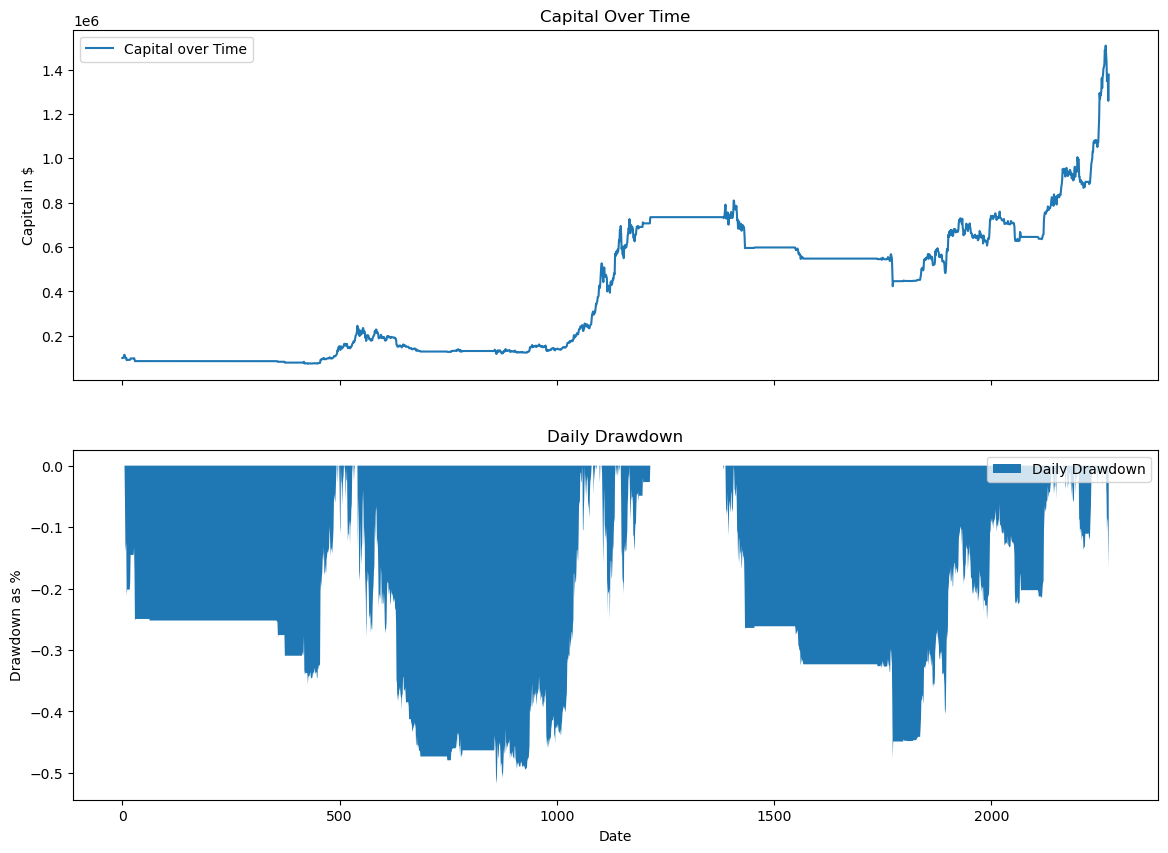

In [19]:
###回撤
# 假设 capital 是一个列表，包含了按时间顺序记录的资本额
capital_series = pd.Series(capital)

# 计算每一天的资本相对于之前的最高值的回撤
rolling_max = capital_series.cummax()
daily_drawdown = (capital_series - rolling_max) / rolling_max

# 计算最大回撤
max_drawdown = daily_drawdown.cummin()
print(f"Maximum drawdown of this model:{abs(max_drawdown.min())*100:.2f}%")

# 绘制资本和回撤图
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# 绘制资本曲线
ax1.plot(capital_series.index, capital_series, label='Capital over Time')
ax1.set_title('Capital Over Time')
ax1.set_ylabel('Capital in $')
ax1.legend()

# 绘制回撤曲线
ax2.fill_between(daily_drawdown.index, daily_drawdown, label='Daily Drawdown')
ax2.set_title('Daily Drawdown')
ax2.set_ylabel('Drawdown as %')
ax2.set_xlabel('Date')
ax2.legend()

plt.show()

### 6.2 计算比特币的最大回撤


In [20]:
filtered_data = market_data[(market_data['date'] >= start_date) & (market_data['date'] <= end_date)]

# 确保数据按日期排序（非常重要）
filtered_data = filtered_data.sort_values('date')

# 计算最大回撤
# 方法是遍历每一个价格点，找到之后所有点的最小价格，计算回撤，持续跟踪最大回撤
max_drawdown = 0
peak_price = filtered_data['btc_price'].iloc[0]
for price in filtered_data['btc_price']:
    if price > peak_price:
        peak_price = price
    drawdown = (peak_price - price) / peak_price
    if drawdown > max_drawdown:
        max_drawdown = drawdown

print(f"Maximum Drawdown of bitcoin price: {max_drawdown*100:.2f}%")

Maximum Drawdown of bitcoin price: 81.20%
